# Reading Spectral Data Files and making the plot

In this notebook it is demonstrated how to read spectral data files from the following sources

* [Fugro/MetOcean](#fugro): Fugru and MetOcean supply their forecasts as transient 2D sea state spectra in either a .csv or an .oct file.
* [Wave Rider Buoy](#wave_rider_buoy): The WRB stores the 2D spectra in .spt files. Each file contains one spectrum.
* [Sea State Components](#spectral_components): An Excel file with the sea state times series of Hs/Tp/Theta0 values for the wind and swell components.
* [NetCDF](#netcdf): All the readers above can be converted from their original spectral data to a more generic NetCDF file. This NetCDF file allows to speed up reading time the next time you run your code as no conversion need to take place anymore.

For each of the type of spectral data a reader class is available. Let's first demonstrate how to read a Fugro file

<a id='fugro'></a>

### Reading a Fugro Spectral Forecast file and making some plots

The Fugro Spectral forecast are distributed as .csv files which contain a series of 2D spectral energy distribution vs time. In this section we show the following:
1. [How to read Fugro/MetOcean Spectral data files](#fugro_reading)
2. [How to access and plot the sea states (Hs/Tp etc)](#fugro_sea_states)
3. [How to access the spectral data](#fugro_accessing)
4. [How to plot the spectral data](#fugro_plotting)

<a id='fugro_reading'></a>

##### Reading the data

Before we start with anything we first load the required modules for all of the examples below

In [1]:
import logging
import os
import sys

import dateutil.parser as dparser   # a data/time parser
import matplotlib.pyplot as plt # the plotter
import seaborn as sns  # make matplotlib figures a bit prettier
import pandas as pd
import numpy as np
from IPython.display import HTML  # allows to add movies to the html output
# import the hmc routines here. Make sure your PYTHONPATH can find the packages
from hmc_utils.misc import (create_logger, Timer)
import hmc_marine.data_readers as dr
from hmc_utils.file_and_directory import scan_base_directory

# some seaborn modifications
sns.set(context="notebook", style="whitegrid", rc={"axes.axisbelow": False})

# create a logger at INFO level. Other choises are DEBUG (lot's of information) and WARNING (only warnings)
logger = create_logger(console_log_level=logging.INFO, console_log_format_clean=True)

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Next step is to load the data file. We first check the data location and modify it if needed. Then we load the file

In [2]:
# the file name
data_location = "data"
if not os.path.isdir(data_location):
    data_location = os.path.join("..", data_location)

# define the file name and extract the start date from the file name using the dparser module
file_name = os.path.join(data_location, "Fugro_I0450_20170510_06.csv")
start_date_time = dparser.parse(os.path.splitext(file_name)[0], fuzzy=True)
logger.info("Reading Fugro file {} with start date/time {}".format(file_name, start_date_time))

# read the spectral data
fugro = dr.WaveSpectralEnergy2DReader(file_name=file_name)

Reading Fugro file ..\data\Fugro_I0450_20170510_06.csv with start date/time 2017-05-10 06:00:00
Reading the wave spectral energy from csv ..\data\Fugro_I0450_20170510_06.csv
Valid For            : 2017-05-10 06:00:00
# Frequencies        :        123
# Directions         :        181
# Records            :         57
Latitude             :       61.4
Longitude            :        1.7
Depth                :      159.4
Frequencies          : None
Directions           : None


At this point we have the time series of spectral data loaded. A new *WaveSpectralEnergy2DReader* object named
*fugro*  has been created which carries all the information. Note that the *dr* in front of the *WaveSpectralEnergy2DReader* call is nothing more than the alias to the *data_reader* module which we assigned above when importing all the modules.

As you can see from the information generated after reading, we have loaded 57 spectral records. Each records is a 2D spectrum over a 3h time span. These sea state spectra are stored in the *spectral_records* field of the *fugro* object we have just created. How to plot the 2D spectra is done [below](#fugro_plotting), but let's have a look at the sea states values vs time first.

<a id='fugro_sea_states'></a>

##### Accessing and plotting the sea states vs Date/Time

Next the the 2D sea state spectra, also some sea state generic information is stored in a separate Pandas DataFrame (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) called *sea_states_df*. We can do anything what we would expect with this DataFrame, so lets show the information with the *info()* method as follows

In [3]:
# the sea state data (scalars with Hs, Tp, Theta, etc) vs date/time is stored  in the sea_states_df DataFrame
sea_states = fugro.sea_states_df
sea_states.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 2017-05-10 06:00:00+00:00 to 2017-05-17 06:00:00+00:00
Data columns (total 25 columns):
WD           57 non-null float64
WS           57 non-null float64
ETot         57 non-null float64
TZ           57 non-null float64
VMD          57 non-null float64
ETotSe       57 non-null float64
TZSe         57 non-null float64
VMDSe        57 non-null float64
ETotSw       57 non-null float64
TZSw         57 non-null float64
VMDSw        57 non-null float64
Mo1          57 non-null float64
Mo2          57 non-null float64
HSig         57 non-null float64
DomDr        57 non-null float64
AngSpr       57 non-null float64
Tau          57 non-null float64
variance     57 non-null float64
Hs           57 non-null float64
Tp           57 non-null float64
Tm           57 non-null float64
Theta0       57 non-null float64
HsTp2true    57 non-null float64
HsTp2        57 non-null float64
Tp_spec      57 non-null float64
dtypes: float64(25)
me

The data frame *sea_states_df* contains 57 columns with sea state information. The first 49 columns are directly obtained from the Fugro data file as each spectral records that is stored starts with a header field with some sea state values. Some example fields are *WD* (Wind Direction), *WS* (Wind Speed), *Etot* (Total Energy), *HSig* (Significant wave height), and *DomDr* (Main wave direction). Starting from the *variance* column the values have been internally derived from the loaded spectrum. The *index* of the DataFrame is obtained from the date/times at which the 2D spectra are stored. 

As we have loaded the sea states in a DataFrame we can peek at the values with the *head()* method as follows.

In [4]:
sea_states.head(5)

WD    WS    ETot    TZ   VMD  ETotSe  TZSe  \
2017-05-10 06:00:00+00:00  48.0  9.39  0.1473  4.57  29.7  0.1274  4.33   
2017-05-10 09:00:00+00:00  43.0  9.78  0.2264  4.98  32.6  0.2053  4.81   
2017-05-10 12:00:00+00:00  40.0  9.25  0.2628  5.16  32.2  0.2319  4.96   
2017-05-10 15:00:00+00:00  38.0  9.10  0.2612  5.17  30.2  0.2275  4.94   
2017-05-10 18:00:00+00:00  35.0  9.48  0.2699  5.23  27.7  0.2332  4.99   

                           VMDSe  ETotSw  TZSw    ...     AngSpr   Tau  \
2017-05-10 06:00:00+00:00   31.9  0.0199  8.94    ...       29.0   0.0   
2017-05-10 09:00:00+00:00   34.2  0.0211  8.82    ...       26.0   3.0   
2017-05-10 12:00:00+00:00   33.8  0.0308  8.63    ...       25.0   6.0   
2017-05-10 15:00:00+00:00   32.1  0.0337  8.58    ...       25.0   9.0   
2017-05-10 18:00:00+00:00   29.8  0.0367  8.55    ...       25.0  12.0   

                           variance        Hs        Tp        Tm     Theta0  \
2017-05-10 06:00:00+00:00  0.153457  1.566945  8.350445  4.879773  21.878453   
2017-05-10 09:00:00+00:00  0.236763  1.946332  6.167846  5.274379  23.867403   
2017-05-10 12:00:00+00:00  0.275188  2.098334  6.815642  5.487995  23.867403   
2017-05-10 15:00:00+00:00  0.273747  2.092833  6.815642  5.511701  21.878453   
2017-05-10 18:00:00+00:00  0.282827  2.127260  6.815642  5.566021  21.878453   

                            HsTp2true      HsTp2   Tp_spec  
2017-05-10 06:00:00+00:00  109.262956  65.495779  6.465168  
2017-05-10 09:00:00+00:00   74.042988  81.106601  6.455348  
2017-05-10 12:00:00+00:00   97.473854  92.628148  6.644070  
2017-05-10 15:00:00+00:00   97.218351  93.549944  6.685816  
2017-05-10 18:00:00+00:00   98.817560  95.803531  6.710896  

[5 rows x 25 columns]

Also we can make plots of the sea states vs time by just using the Pandas DataFrame plot method in combination with matplotlib. Let's make a plot of some sea states vs time:

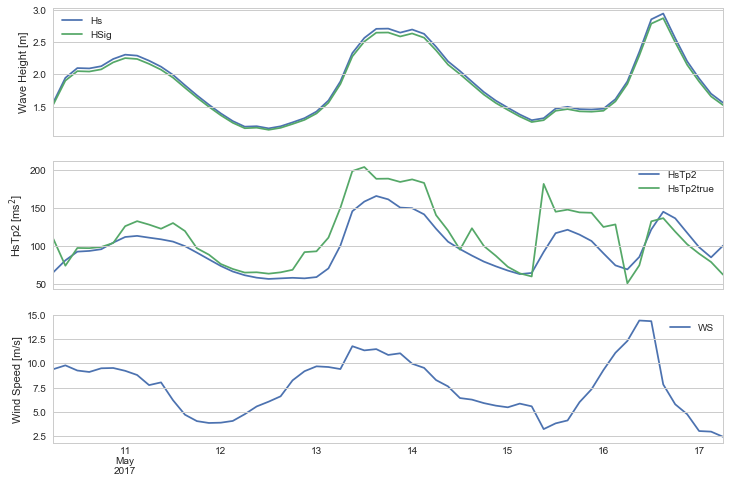

In [5]:
fig, axis = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(12, 8))
plt.subplots_adjust(wspace=0.4)

# top plot
sea_states.plot(y=["Hs", "HSig"], ax=axis[0])
axis[0].set_ylabel("Wave Height [m]")

# bottom plot
sea_states.plot(y=["HsTp2", "HsTp2true"], ax=axis[1])
axis[1].set_ylabel("HsTp2 [ms$^2$]")

sea_states.plot(y=["WS"], ax=axis[2])
axis[2].set_ylabel("Wind Speed [m/s]")

plt.show()


Note that we have used the *subfigures* method of *matplotlib* to set up the figures, which returns a list of the three subplots to *axis*. The three individual subplots, *axis[0]*, *axis[1]*, *axis[2]*, are subsequently passed to the Pandas plotting routines via the *ax* input argument in order to put the plots in its own subplot. This is just standard Pandas stuff. Please have a look at the Pandas documentation for more information on plotting of DataFrames.

In the three plots we show the significant wave height (top), HsTp2 quantity (middle), and wind speed (bottom). For the significant wave height we compare the values as stored in the Fugro data files directly as *HSig* with the significant wave height *Hs* as obtained from the power spectral density. As expected, up to some numerical round off errors (as we needed to interpolate the spectrum from a non-uniform to a uniform mesh), the values are the same. 

For the HsTp2 plot we compare the *HsTp2true* which is based on the *Tp* as obtained from the 2D spectrum by picking location of the peak in the PSD and the spectral *HsTp2* definition as used within HMC. See the doctstring information on the *set_psd_properties* of the *WaveSpectralDensity2DRecord* for more information. 

The bottom plot show the wind speed just as recorded with in the Fugro data file. No alteration have been made. In EnviView the wind speed is scaled so the values turn out to be about 10% higher. It can be validated by looking at the Hs/HsTp2/Vw plot in EnviView that the Hs and HsTp2 are identical.

<a id='fugro_accessing'></a>

##### Accessing the spectral data

The list of 2D spectra are stored in the *spectral_records* dictionary. Just like any dictionary we can loop over all the key, value combinations using the *items()* method. The key field is a Date/Time object belonging to the spectral record. Here an example how to loop over all the records. The *enumerate* is only used to keep a counter so we can stop after 2 records.

In [6]:
for i, (date_time, spectral_record) in enumerate(fugro.spectral_records.items()):
    if i > 1:
        break
    logger.info("{}\n{}".format(type(spectral_record), spectral_record.header_df[["Tp", "Hs", "Theta0"]].head()))
    

<class 'hmc_marine.data_readers.WaveSpectralEnergy2DRecord'>
                           Tp        Hs     Theta0
2017-05-10 06:00:00  8.350445  1.566945  21.878453
<class 'hmc_marine.data_readers.WaveSpectralEnergy2DRecord'>
                           Tp        Hs     Theta0
2017-05-10 09:00:00  6.167846  1.946332  23.867403


The fugro data object *WaveSpectralEnergy2DReader* holds the time series of individual records objects *WaveSpectralEnergy2DRecord* in the *spectral_records* dictionary. Each records holds in its turn a header_df field which can be report with the *report()* method. The header_df is a DataFrame of one line (one single Date/Time of that record). We have already seen this data as the *sea_states_df* field of the fugro object holds the collection of all the headers of the time series. 

A single WaveSpectralEnergy2DRecord can also be accessed by its data time. Let's explicity do that. The key values of the dictionary are Pandas Timestamps which contain the time zone information. We can make a time stamp by using the Timestamp method with the `tz` time zone information field set. Setting the time zone is important as without the time zone the key field can not be recognised. By default to time zone of the data is "UTC".

In [7]:
time_stamp = pd.Timestamp("2017-05-10 12:00:00", tz="UTC")
logger.info("Getting the reference to the spectral record at {}".format(time_stamp))
spectral_record = fugro.spectral_records[time_stamp]

Getting the reference to the spectral record at 2017-05-10 12:00:00+00:00


We can  access the the power spectral density data of a *WaveSpectralEnergy2DRecord* via its psd_2d field

In [8]:
psd = spectral_record.psd_2d
logger.info("psd data: type = {}. shape = {}. item type = {}".format(type(psd), psd.shape, type(psd[0][0])))

psd data: type = <class 'numpy.ndarray'>. shape = (123, 181). item type = <class 'numpy.float64'>


It is shown that the psd_2d is just an ordinary numpy array of 123 x 181 values on a frequecy x direction mesh (the report we made in the start told us that we had loaded spectra on a mesh with 123 frequency and 181 direction indeed). The frequency and direction are stored on the following 1D arrays:

In [9]:
ff = spectral_record.freq_in_hz
logger.info("freq data: type = {}. shape = {}. item type = {}".format(type(ff), ff.shape, type(ff[0])))
dd = spectral_record.directions_deg
logger.info("freq data: type = {}. shape = {}. item type = {}".format(type(dd), dd.shape, type(dd[0])))

freq data: type = <class 'numpy.ndarray'>. shape = (123,). item type = <class 'numpy.float64'>
freq data: type = <class 'numpy.ndarray'>. shape = (181,). item type = <class 'numpy.float64'>


Note that the frequency and directions of the PSD are defined in Hz and degrees and stored in the *freq_in_hz* and *directions_deg* fields. The direction axis in radians has been stored on the *directions* field but for the scaling of the psd the direction_deg axis has been used (the units of the psd are m2s/deg)

<a id='fugro_plotting'></a>

##### Plotting the spectral data

Of course we could continue from here by plotting the spectral data stored in the numpy arrays using the matplotlib functions or do anything we want with the data. The WaveSpectralEnergy2DRecord, however, has some plotting cababilities which we can use to make a plot of the data. Let's do that now

Getting data at 2017-05-10 06:00:00+00:00 <class 'pandas._libs.tslib.Timestamp'>


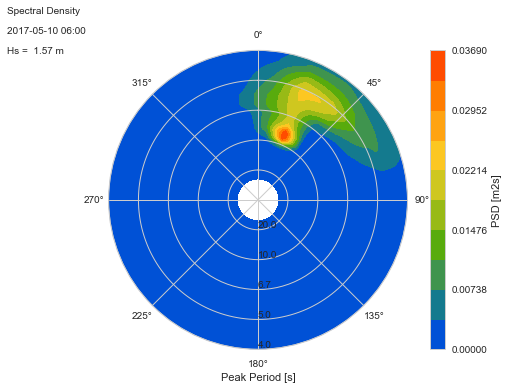

In [10]:
# fugro.plot_frame(frame_datetime="20170516T060000", r_axis_lim=(0, 0.25))

fig, axis = fugro.plot_frame(frame_index=0, r_axis_lim=(0, 0.25), plot_title="Spectral Density")
plt.show()


The *plot_frame* method of the *WaveSpectralEnergy2Dreader* object accepts either a *frame_index* or a *frame_datetime* as input argument to specify which record to plot. The first version allows to specify the plot without finding out which date/times are available in the loaded data set. The second version allows to pick a specific date, but of course, it needs to be available.

Note furthermore that we can specify the type of the r_axis with the *r_axis_type* argument as either "frequency" or "period" (see the documentation for more details). In the latter case, the frequency labels are simply replaced by the corresponding period values, so from the inner to the outer grid-ring we can see the values T=20 s (0.05 Hz) to T=4 s  (0.25 Hz). The *r_axis_lim* is always specified in terms of frequency, also in case we have choosen *r_axis_type* to be 'period'. So in this example we set the frequency range from 0 to 0.25 Hz.

Making a movie out of a series of data frames is not difficult as well. You can just do

In [11]:
movie = fugro.animate_frames(r_axis_lim=(0, 0.25), min_data_value=0, max_data_value=0.05, plot_title="PSD animation")
HTML(movie.to_html5_video())
# the HTML command should replace with plt.show() if we are working in a python script

In [12]:
plt.gcf().clear()

The input arguments are the same as the plot_frame method. The only difference is that a loop over all the spectral records is made. Also you have to make sure the specify the min/max of the contour range via the *min_data_value* and *max_data_value* input argument, otherwise the contour colors are scaled to its maximum range for each range.

##### Some remarks on the data structure. 

The spectral energy stored in the files from Fugro/MetOcean is defined at mesh with a non-uniform frequency bin spacing in order to put more bins near the peak of the spectrum. The reader class *WaveSpectralEnergy2DReader* stores the individial 2D spectral energy distribution to a dictionary in which each key/value pair contains an object *WaveSpectralEnergy2DRecord*. This record still describes the data a energy per bin on a non-uniform mesh (i.e. not equidistant on the frequency and directions axis) . However, this class has an ancestor class which is the *WaveSpectralDesity2DRecord* which stores the 2D power spectral spectral density. The plotting methods are al defined at the level of this *WaveSpectralDensity2DRecords*. The *WaveSpectralEnergy2DReader* in it self is also based on a lower class *WaveSpectralDensity2DReader*. This latter class caries some basic functionality such a making the plots and the animations which can be shared amongst other reader classes

The benefit of this method is that we can also base different types of spectral readers on the same base class. For instance, the *WaveSpectralMomentsQ2Reader* is the reader class for the wave rider buoy data. Again, this class has a *spectral_records* field carrying the individual records as *WaveSpectralMomentsQ2Records*. This class also inherits from the base class *WaveSpectral2DRecords* and therefore all the plotting methods can be used. This will be demonstrated in the next section.

<a id='wave_rider_buoy'></a>

### Reading the Wave Rider Buoy Spectral data and  making some plots

Reading and plotting the spectral data obtained from the Wave Rider buoy follows almost the same procedure as reading and plotting the Fugro data. There are two major differences

1. The wave rider buoy stores the spectral data for each record in one file, whereas Fugro stores a time series of subsequent 2D spectra into one file. If we want to construct a spectral time series from the WRB data we therefore need to give a list of file names as an input to the reader
2. The wave rider buoy stores the spectral data in a very efficient manner by just defining the first four moments (i.e. mean, width, skewness and flatness) of the directional distribution per frequency bin . This implies that for one signal frequency bin we can have only one major direction (which is the mean value). For this reason the spectral data is refered to as quasi-2D as we can not have more than one wave direction per the frequency bin. 

Let's first have a look at an examples. The details are discussed below that.

##### Reading the data

First we need to specifiy the list of file we want to read. So can be done fairly easy with the *scan_base_directory* function from the hmc_utils package. We have already imported the function above, so let's go:

In [13]:
wrb_files = scan_base_directory(data_location, file_has_string_pattern="Mur.*", extension=".spt")
logger.info("# of files found: {}".format(len(wrb_files)))

#read the first two files only
wrb = dr.WaveSpectralMomentsQ2DReader(file_names=wrb_files[:2])


# of files found: 55
Read the WRB spectral moments from ..\data\WRB\Murchison 2017}2017-05-10T00h01Z.spt in 4.0 s
Read the WRB spectral moments from ..\data\WRB\Murchison 2017}2017-05-10T00h31Z.spt in 4.1 s


As you could notice: the reading of the spectral data is time consuming due to the method under the hood to convert the spectral moments vs frequency into a plain 2D power spectral density. Below we will demonstrate how deal with this. But first show the plot of the first spectral data file

Getting data at 2017-05-10 00:01:00+00:00 <class 'pandas._libs.tslib.Timestamp'>


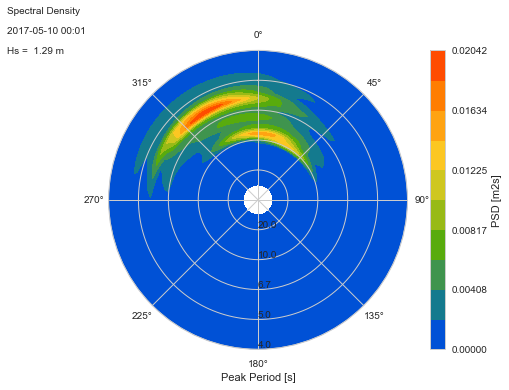

In [14]:
fig, axis = wrb.plot_frame(frame_index=0, r_axis_lim=(0, 0.25), plot_title="Spectral Density")
plt.show()

###### Some remarks

As the wave rider buoy has a fundamental different representation than the Fugro spectral data we need another reader class for the data, which is called *WaveSpectralMomentsQ2DReader*. The MomentsQ2D refers to the quasi-2D (Q2D) way of storing the data by its moments. Nevertheless, as already mentioned above, both the WaveSpectralEnergy2DReader and WaveSpectralMomentsQ2DReader class inherit from the same base class WaveSpectralDensity2DReader. Therefore most of the functionality is shared. For this reason the plotting of the data can be  done in exactly the same. 

<a id='spectral_components'></a>

### Reading the Spectral wave component data and  making some plots

The last spectral reader classs is the *WaveSpectralComponentsReader* which read an excel data base in which the Hs/Tp/Theto0 for the wind and swell components is listed vs DataTime. Then, based on the assumed spectral shape per wave component we can construct the 2D spectum. 

##### Reading the data

Let's first read the data which is stored in the excel file

In [15]:
file_name = os.path.join(data_location, "murchison_seastates_20160807.xls")
start_date_time = dparser.parse(os.path.splitext(file_name)[0], fuzzy=True)
logger.info("Reading Spectral components file {} with start date/time {}".format(file_name, start_date_time))

spectrum = dr.WaveSpectralComponentsReader(file_name=file_name)

Reading Spectral components file ..\data\murchison_seastates_20160807.xls with start date/time 2016-08-07 00:00:00
No spectral components are supplied by the user. Imposing defaults


Make a plot is done in exacly the same way as we did before

Getting data at 2016-08-07 03:00:00+00:00 <class 'pandas._libs.tslib.Timestamp'>


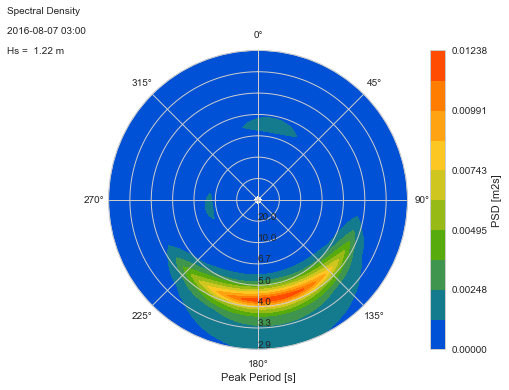

In [16]:
fig, axis = spectrum.plot_frame(frame_index=0, r_axis_lim=(0, 0.33), plot_title="Spectral Density")
plt.show()

The sea states properties are again stored in the sea_state_df DataFrame of *WaveSpectralComponentsReader* object, just as we have seen with the Fugro data reader. We can have a look at it

In [17]:
spectrum.sea_states_df.head(5)

Hs_swell  Tp_swell  direction_wave_swell  \
2016-08-07 03:00:00+00:00  0.280000     5.655              9.840000   
2016-08-07 06:00:00+00:00  0.220000     6.945            136.164989   
2016-08-07 09:00:00+00:00  0.140000     7.000            134.509990   
2016-08-07 12:00:00+00:00  0.236667     6.455             49.741665   
2016-08-07 15:00:00+00:00  0.530000     7.825            136.204997   

                           Hs_swell2  Tp_swell2  direction_wave_swell2  \
2016-08-07 03:00:00+00:00      0.225      8.375             262.214996   
2016-08-07 06:00:00+00:00      0.190      7.170             136.969998   
2016-08-07 09:00:00+00:00      0.110      6.455              17.465000   
2016-08-07 12:00:00+00:00      0.060      6.920              23.330000   
2016-08-07 15:00:00+00:00      0.060      6.920              23.330000   

                           Hs_wind  Tp_wind  direction_wave_wind  variance  \
2016-08-07 03:00:00+00:00    1.165    4.335           171.164993  0.092716   
2016-08-07 06:00:00+00:00    1.920    5.705           166.669998  0.238380   
2016-08-07 09:00:00+00:00    2.260    6.560           172.214996  0.327261   
2016-08-07 12:00:00+00:00    2.205    6.835           184.979996  0.303154   
2016-08-07 15:00:00+00:00    2.395    6.930           196.894997  0.367537   

                                 Hs        Tp        Tm      Theta0  \
2016-08-07 03:00:00+00:00  1.217971  4.264243  3.761761  171.333333   
2016-08-07 06:00:00+00:00  1.952968  5.771050  4.806355  166.666667   
2016-08-07 09:00:00+00:00  2.288269  6.541555  5.496016  172.000000   
2016-08-07 12:00:00+00:00  2.202378  6.541555  5.686768  184.666667   
2016-08-07 15:00:00+00:00  2.424993  6.541555  5.825777  196.666667   

                            HsTp2true       HsTp2   Tp_spec  
2016-08-07 03:00:00+00:00   22.147307   27.929026  4.788609  
2016-08-07 06:00:00+00:00   65.043623   60.502003  5.565925  
2016-08-07 09:00:00+00:00   97.919462   91.717659  6.331010  
2016-08-07 12:00:00+00:00   94.244015   95.172377  6.573695  
2016-08-07 15:00:00+00:00  103.770140  110.716932  6.756967

The fields upto the *variance* column are the spectral components as obtained from the Excel input file (you can check this by comparing with the input file). The columns following the *variance* columns are the Hs/Tp/direction values as obtained from the constructed Power Spectral Density. We can easily validate this by for instance checking if the Hs is indeed following from its spectral components wave heights:

In [18]:
df = spectrum.sea_states_df
df["HsTot"] = np.sqrt(df.Hs_wind**2 + df.Hs_swell**2 + df.Hs_swell2**2)
df[["HsTot", "Hs"]].head()

HsTot        Hs
2016-08-07 03:00:00+00:00  1.219118  1.217971
2016-08-07 06:00:00+00:00  1.941880  1.952968
2016-08-07 09:00:00+00:00  2.267002  2.288269
2016-08-07 12:00:00+00:00  2.218476  2.202378
2016-08-07 15:00:00+00:00  2.453676  2.424993

As you can see, the HsTot (which is constructed from the individual components) is the same as the Hs which is obtained from the constructed power spectral density function. 

Another trick we can do is adding a scatter point on the component location in the plot. We used the *report_all_components* method for this which allows to give a summary of the sea state components of a certain time step. Let's first call this method to show what it does


In [19]:
comp = spectrum.report_all_components(record_index=0)

Properties at 2016-08-07 03:00:00+00:00
Sea state values of swell1               Hs=0.28 m, Tp = 5.7 s, Theta0 = 9.8
Sea state values of swell2               Hs=0.22 m, Tp = 8.4 s, Theta0 = 262.2
Sea state values of wind_waves           Hs=1.16 m, Tp = 4.3 s, Theta0 = 171.2


As you can see, the *report_all_components* just returns the values for the wave types we have at that moment. We can run this method also silently and just returns the values Hs/Tp/Theta0 for one particular component. These values are returned in a data frame with the columns "Hs", "Tp", and "Theta0". So in order to add scatter points to our component locations we just create the plot again, loop over the components and add a scatter point.

Getting data at 2016-08-07 03:00:00+00:00 <class 'pandas._libs.tslib.Timestamp'>


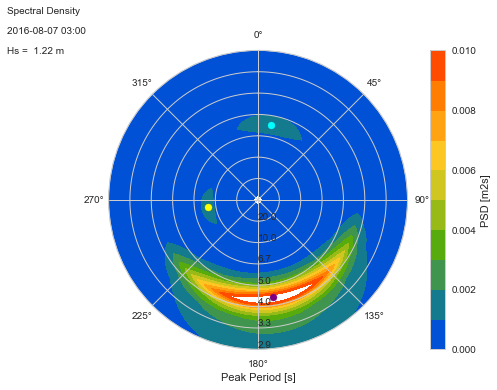

In [20]:
fig, axis = spectrum.plot_frame(frame_index=0, r_axis_lim=(0, 0.33), plot_title="Spectral Density", 
                                max_data_value=.01)
# note that the zip statement just 'zips' the two lists with the component names and colors belonging to it. This 
# make it easier to set a color to each component scatter point (i.e. wind_waves is purple, swell1 is cyan, etc)
for (name, color) in zip(["wind_waves", "swell1", "swell2"], ["purple", "cyan", "yellow"]):
    component = spectrum.report_all_components(record_index=0, component_to_return=name, quiet=True)
    theta = np.deg2rad(component["Theta0"])  # for the polar plotting we need to convert degrees to rad!
    freq = 1.0/ component["Tp"].values
    axis.scatter(theta, freq, c=color)

plt.show()
        

We can make a movie again by using the *animate_frames* method..

In [21]:
movie2 = spectrum.animate_frames(r_axis_lim=(0, 0.33), min_data_value=0, max_data_value=0.05, plot_title="PSD animation")
HTML(movie2.to_html5_video())

In [22]:
plt.gcf().clear()

<a id='netcdf'></a>

### Speeding up your data readers: NetCDF

As already mentioned above, the reading of spectral data can be a pain as it takes quite some time. Especially the reading of the wave rider buoy data is really time consuming. It would be a bit painful if we would have to go through the slow reading process each time we are making a plot of the same data. 

Luckily, for all spectral data readers a method is implemented which automatically stores the data to a NetCDF file (https://www.unidata.ucar.edu/software/netcdf/). NetCDF is a generic file format which can be read by many other programs (such as Paraview and Matlab), so it is also a convenient way to convert the data to something more accessible by other programs.

Let demonstrate our point with this list of wave rider buoy files which we have already defined in the section above. In the previous section we picked only 2 files to read in order to save time. But for this purpose we are now going to read all the 55 data files. We are going to do this 2 times: one time by just reading the original spt files. This time however, we are going to store all the converted spectra to a NetCDF data base. The next time we just read the data from the data base and save, as we will see, a lot of time. 

##### Reading the data

A special class has been defined to enable to create a NetCDF data base a bit more easy: *NetCDFInfo*. We start with setting up the class



In [23]:
netcdf = dr.NetCDFInfo(file_location=data_location, reset_netcdf=True)

We have done not much more than creating a netcdf_info object with the *reset_netcdf* flag set to True. This that in case we have already created a netcdf data base, it will be cleared and we start building the date base from scratch. 

Now we can start with importing all the NetCDF files. We do this with all the files except for the list three files (so we make a selection using [:-3]). This will take quite some time, so take a brake and grab a coffee when we are doing the next step..

In [24]:
with Timer(message="Reading from spt", units="s") as timer:
    wrb_example = dr.WaveSpectralMomentsQ2DReader(file_names=wrb_files[:-3], n_frequencies=60, n_directions=360,
                                                  data_base_name="example", netcdf=netcdf)

Creating new netcdf data base ..\data\envi_db_example_20170510T0001.nc
Read the WRB spectral moments from ..\data\WRB\Murchison 2017}2017-05-10T00h01Z.spt in 2.4 s
Read the WRB spectral moments from ..\data\WRB\Murchison 2017}2017-05-10T00h31Z.spt in 2.4 s
Read the WRB spectral moments from ..\data\WRB\Murchison 2017}2017-05-10T01h02Z.spt in 2.7 s
Read the WRB spectral moments from ..\data\WRB\Murchison 2017}2017-05-10T02h01Z.spt in 2.6 s
Read the WRB spectral moments from ..\data\WRB\Murchison 2017}2017-05-10T02h32Z.spt in 2.8 s
Read the WRB spectral moments from ..\data\WRB\Murchison 2017}2017-05-10T03h01Z.spt in 2.4 s
Read the WRB spectral moments from ..\data\WRB\Murchison 2017}2017-05-10T03h31Z.spt in 2.4 s
Read the WRB spectral moments from ..\data\WRB\Murchison 2017}2017-05-10T04h02Z.spt in 2.3 s
Read the WRB spectral moments from ..\data\WRB\Murchison 2017}2017-05-10T04h31Z.spt in 2.3 s
Read the WRB spectral moments from ..\data\WRB\Murchison 2017}2017-05-10T05h01Z.spt in 2.3 s

The reading took more than 2 minutes. We could now continue with make the plots etc. But for this example, let's read the data again, but this time with the reset_netcdf flag to False. Also, we suply the data file list including the last 3 files which we left the first time. 

In [25]:
netcdf.reset_netcdf = False

with Timer(message="Reading without reset", units="s") as timer:
    wrb = dr.WaveSpectralMomentsQ2DReader(file_names=wrb_files, n_frequencies=60, n_directions=360,
                                          data_base_name="example", netcdf=netcdf
                                          )

Read the wave spectral moments from ..\data\envi_db_example_20170510T0001.nc in 0.6 s
Read the WRB spectral moments from ..\data\WRB\Murchison 2017}2017-05-11T03h31Z.spt in 2.4 s
Read the WRB spectral moments from ..\data\WRB\Murchison 2017}2017-05-11T04h02Z.spt in 2.4 s
Read the WRB spectral moments from ..\data\WRB\Murchison 2017}2017-05-11T04h31Z.spt in 2.4 s
Reading without reset routine              :          9 s


This time it took only 8 seconds, and that was only because we needed to read the last spt files which where not stored in the NetCDF data base yet. This demonstrates how you can extend you data base: every day when some new spt files are available they are converted to 2D spectra and appended to the data base, so that the next time you don't have to do that again.

Just to finish off, read the data again with the same data set. 


In [26]:
wrb = dr.WaveSpectralMomentsQ2DReader(file_names=wrb_files, n_frequencies=60, n_directions=360,
                                      data_base_name="example", netcdf=netcdf)

Read the wave spectral moments from ..\data\envi_db_example_20170510T0001.nc in 0.8 s


All the data was already in the NetCDF data base, so the reading took less than a second. It shows the benefit of a small effort we did by setting up the NetCDF. Another advantage is that we can easily import the spectral data into ParaView or Matlab or any other package that is able to read NetCDF data files.

##### Plotting the data

To close this example, let's make a nice movie of the wave rider buoy data. As to be expected, it is done in the same way as we did for the Fugro data and the Wave component data:

In [27]:
movie3 = wrb.animate_frames(r_axis_lim=(0, 0.33), min_data_value=0, max_data_value=0.02, plot_title="PSD animation")
HTML(movie3.to_html5_video())